In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pythautomata.utilities import pdfa_generator
from pythautomata.utilities import nicaud_dfa_generator
from src import utils, constants
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display
from src.hypothesis_aware_sample_probabilistic_teacher import HypothesisAwareSampleProbabilisticTeacher
from src.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
from pymodelextractor.teachers.sample_probabilistic_teacher import SampleProbabilisticTeacher
from pythautomata.utilities.probability_partitioner import QuantizationProbabilityPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
from pymodelextractor.learners.observation_tree_learners.pdfa_quantization_n_ary_tree_learner import PDFAQuantizationNAryTreeLearner

# Create a random PDFA with zero-transitions

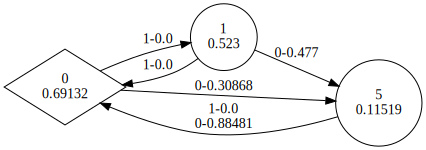

In [2]:
size = 5
dfa = nicaud_dfa_generator.generate_dfa(alphabet = constants.binaryAlphabet, nominal_size= size, seed = 42)
dfa.name = "random_PDFA_nominal_size_"+str(size)   
pdfa = pdfa_generator.pdfa_from_dfa(dfa, zero_probability=0.3)  


exporter = WFADotExportingStrategy()
graph = exporter.create_graph(pdfa)

display(graph)    

# Extractions

In [3]:
max_seq_length = 10
partitions = 1000   
partitioner = QuantizationProbabilityPartitioner(partitions)
partition_comparator = WFAPartitionComparator(partitioner)
teacher1 = HypothesisAwareSampleProbabilisticTeacher(model = pdfa, comparator = partition_comparator, sample_size = 1000, max_seq_length = max_seq_length)
learner1 = PDFAQuantizationNAryTreeLearner(omit_zero_transitions = True, probabilityPartitioner = partitioner, check_probabilistic_hipothesis = False)

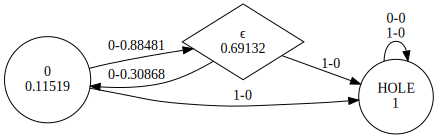

In [4]:
result = learner1.learn(teacher1)
graph = exporter.create_graph(result.model)
display(graph) 

In [5]:
undefined_ouput = np.zeros(len(pdfa.alphabet)+1)
synchronic_model = SyncronicModelGuidedLanguageModel(pdfa, guiding_model=None, model_name= pdfa.name+"_SYNCH", max_seq_length=10, 
                                                        normalize_outputs=False, top_k=len(pdfa.alphabet)+1, check_is_defined=True, 
                                                        undefined_ouput=undefined_ouput)
teacher2 =  SampleProbabilisticTeacher(synchronic_model, comparator = partition_comparator, sample_size = 100, max_seq_length = 25)
learner2 = PDFAQuantizationNAryTreeLearner(omit_zero_transitions = False, probabilityPartitioner = partitioner, check_probabilistic_hipothesis = False)

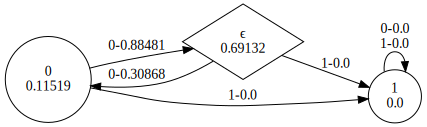

In [6]:
result2 = learner2.learn(teacher2)
graph = exporter.create_graph(result2.model)
display(graph) 

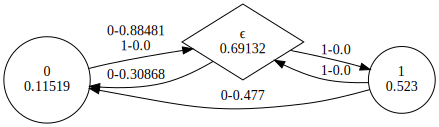

In [7]:
teacher3 =  SampleProbabilisticTeacher(pdfa, comparator = partition_comparator, sample_size = 100, max_seq_length = 25)
learner3 = PDFAQuantizationNAryTreeLearner(omit_zero_transitions = False, probabilityPartitioner = partitioner, check_probabilistic_hipothesis = False)
result3 = learner3.learn(teacher3)
graph = exporter.create_graph(result3.model)
display(graph) 

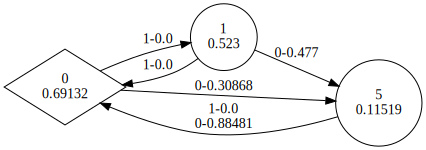

In [8]:
graph = exporter.create_graph(pdfa)

display(graph) 

In [9]:
sg2 = GuidingWDFASequenceGenerator(pdfa, max_seq_length, random_seed=42)
sequences_in_target = sg2.generate_words(100)  

In [10]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
sequence = Sequence([SymbolStr('0'), SymbolStr('1')])
synchronic_model.check_sequence_is_defined(sequence)

False